# Wer kommt zu Wort `erweitert`

Anlässlich des internationalen Frauentages 2020 veröffentlichte [Open Discourse](https://opendiscourse.de/) eine anschauliche Grafik, in der abgebildet wird, wie viele Redebeiträge der einzelnen Parteien von Frauen kamen. Davon inspiriert haben wir nicht nur diese rekonstruiert, sondern auch weitere Grafiken zur Demografie der Redner:innen erstellt.

Dieses Notbook gewährt einen Einblick in die Datenstruktur des Open Discourse Datensatzes und dient als Beispiel, wie eine solche Visualisierung in Python mit [Pandas](https://pandas.pydata.org/) erstellt werden kann. Der Datensatz wird von Open Discourse öffentlich zur Verfügung gestellt und kann [hier](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/FIKIBO) heruntergeladen werden. Im Folgenden verwenden wir die Dateien im CSV-Format.

In [1]:
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
root = join("CSV Files")

In [3]:
speeches = pd.read_csv(join(root, "speeches.csv"))
# remove id
speeches.index = speeches["id"]
speeches = speeches.drop(columns=["id"])

In [4]:
politicians = pd.read_csv(join(root, "politicians.csv"))

In [5]:
factions = pd.read_csv(join(root, "factions.csv"))

In [6]:
speeches

,session,electoralTerm,politicianId,factionId,positionShort,positionLong,speechContent,date
id,,,,,,,,
1,2,1,-1,-1,Guest,präsident des bundesrats,"Der Bundesrat ist versammelt, Herr Präsident.\n",-640749600
3,2,1,-1,-1,Guest,bundespräsident,"Ja, ich habe den Wunsch.\n",-640749600
5,2,1,-1,-1,Guest,bundespräsident,"Verehrte Mitglieder des Bundestags, des Bundes...",-640749600
23,5,1,-1,-1,Chancellor,NaN,NaN,-640058400
123,7,1,-1,21,Member of Parliament,NaN,Meine Damen und Herren! Der Herr Bundeskanzler...,-639885600
...,...,...,...,...,...,...,...,...
845846,242,18,11004973,-1,Minister,bundesministerin für bildung und forschung,"\nWenn ich es alleine machen könnte, könnte ic...",1498600800
845849,242,18,11004973,-1,Minister,bundesministerin für bildung und forschung,"\nNatürlich habe ich mich sofort, als in der T...",1498600800
846479,244,18,11004973,-1,Minister,bundesministerin für bildung und forschung,\nFrau Präsidentin! Verehrte Abgeordnete! Mein...,1498773600


Hier filtern wir den DataFrame nach Reden, bei denen Politiker\*in und Fraktion zugeordnet wurde:

In [7]:
polit_speeches = speeches[speeches["politicianId"] != -1]
polit_speeches = polit_speeches[polit_speeches["factionId"] != -1]

Nun fügen wir dem DataFrame für jede Rede die entsprechenden Spalten für Politiker\*in und Fraktion hinzu:

In [8]:
polit_speeches = polit_speeches.merge(politicians, left_on="politicianId", right_on="id")

In [9]:
polit_speeches = polit_speeches.merge(factions, left_on="factionId", right_on="id")

Jetzt filtern wir unseren DataFrame nach den Fraktionen, die in der aktuellen Wahlperiode im Bundestag vertreten sind:

In [10]:
polit_speeches["abbreviation"].unique()

array(['CDU/CSU', 'FDP', 'SPD', 'KPD', 'DP', 'Gast', 'BP', 'FU', 'Z',
       'Grüne', 'Fraktionslos', 'GB/BHE', 'DA', 'FVP', 'PDS', 'SSW',
       'DIE LINKE.', 'WAV', 'NR', 'DRP', 'AfD'], dtype=object)

In [11]:
# merge linke and pds
faction_names = polit_speeches["abbreviation"]
polit_speeches.loc[(faction_names == "DIE LINKE.") | (faction_names == "PDS"), "abbreviation"] = "PDS/DIE LINKE."
# only choose subset of factions to plot
relevant_factions = ["Grüne", "PDS/DIE LINKE.", "AfD", "CDU/CSU", "SPD", "FDP"]
relevant_speeches = polit_speeches[polit_speeches.apply(lambda row: row["abbreviation"] in relevant_factions, axis=1)]

### Hilfsvariablen und Funktionen

In [12]:
# define color list corresponding to the factions to plot
polit_colors = ['b', 'k',  'yellow', 'lime', 'm', 'r']

In [13]:
# keep a list with all election years
# election_years = [x * 4 + 1949 for x in range(19)]
# unfortunately, the election years were not as regular as one may think
election_years = [1949, 1953, 1957, 1961, 1965, 1969, 1972, 1976, 1980, 1983, 1987, 1990, 1994, 1998, 2002, 2005, 2009, 2013, 2017, 2021]

In [14]:
def posix_to_timedelta(timestamp):
    if timestamp < 0:
        return datetime(1970, 1, 1) + timedelta(seconds=timestamp)
    else:
        return datetime.utcfromtimestamp(timestamp)

In [15]:
def male_female_ratio(df):
    females = df[df["gender"] != "männlich"]
    ratio = len(females) / len(df)
    return ratio

In [16]:
def academic_ratio(df):
    academics = df[df["academicTitle"].notna()]
    ratio = len(academics) / len(df)
    return ratio

In [17]:
def birth_country_ratio(df):
    german = df[df["birthCountry"] == "Deutschland"]
    ratio = len(german) / len(df)
    return ratio

In [18]:
year_relevant_speeches = relevant_speeches.copy(deep=True)
year_relevant_speeches["date"] = year_relevant_speeches["date"].apply(lambda x: posix_to_timedelta(int(x)).year)

In [19]:
year_relevant_speeches.head()

,session,electoralTerm,politicianId,factionId,positionShort,positionLong,speechContent,date,id_x,firstName,...,academicTitle,aristocracy,birthCountry,birthPlace,birthYear,deathYear,profession,id_y,abbreviation,fullName
0,38,5,11000001,4,Member of Parliament,NaN,Frau Präsidentin! Meine Damen und Herren! Ich ...,1966,11000001,Manfred,...,Prof. Dr.,NaN,Deutschland,Stuttgart,1930-10-20,2008-01-17,"Rechtsanwalt, Wirtschaftsprüfer, Universitätsp...",4,CDU/CSU,Christlich Demokratische Union Deutschlands/Ch...
1,41,5,11000001,4,Member of Parliament,NaN,Meine Damen und Herren! Mir ist zwar nicht gan...,1966,11000001,Manfred,...,Prof. Dr.,NaN,Deutschland,Stuttgart,1930-10-20,2008-01-17,"Rechtsanwalt, Wirtschaftsprüfer, Universitätsp...",4,CDU/CSU,Christlich Demokratische Union Deutschlands/Ch...
2,41,5,11000001,4,Member of Parliament,NaN,"Herr Dorn, ich bin gern bereit, auf diese Frag...",1966,11000001,Manfred,...,Prof. Dr.,NaN,Deutschland,Stuttgart,1930-10-20,2008-01-17,"Rechtsanwalt, Wirtschaftsprüfer, Universitätsp...",4,CDU/CSU,Christlich Demokratische Union Deutschlands/Ch...
3,42,5,11000001,4,Member of Parliament,NaN,Herr Präsident! Meine Damen und Herren! Ich mö...,1966,11000001,Manfred,...,Prof. Dr.,NaN,Deutschland,Stuttgart,1930-10-20,2008-01-17,"Rechtsanwalt, Wirtschaftsprüfer, Universitätsp...",4,CDU/CSU,Christlich Demokratische Union Deutschlands/Ch...
4,111,5,11000001,4,Member of Parliament,NaN,Herr Präsident! Meine Damen und Herren! Ich ve...,1967,11000001,Manfred,...,Prof. Dr.,NaN,Deutschland,Stuttgart,1930-10-20,2008-01-17,"Rechtsanwalt, Wirtschaftsprüfer, Universitätsp...",4,CDU/CSU,Christlich Demokratische Union Deutschlands/Ch...


# Analysen
Wir untersuchen die folgenden Variablen jeweils pro Fraktion und pro Jahr.
1. **Gesamtzahl** der Reden
2. **Frauenanteil** unter den Redner:innen. Repliziert die Grafik "Wer kommt zu Wort - Männer oder Frauen?" von [OpenDiscourse](https://opendiscourse.de/_next/image?url=%2Fimages%2Fstatistics%2Fwer_kommt_zu_wort.png&w=3840&q=75)
5. **Durchnittsalter** der Redner:innen
3. Anteil der Redner:innen mit **akademischem Titel**
4. Anteil der Redner:innen, die **in Deutschland geboren** sind

In [20]:
count_year_faction = year_relevant_speeches.groupby("abbreviation").apply(lambda faction: faction.groupby("date").apply(lambda group: len(group)))

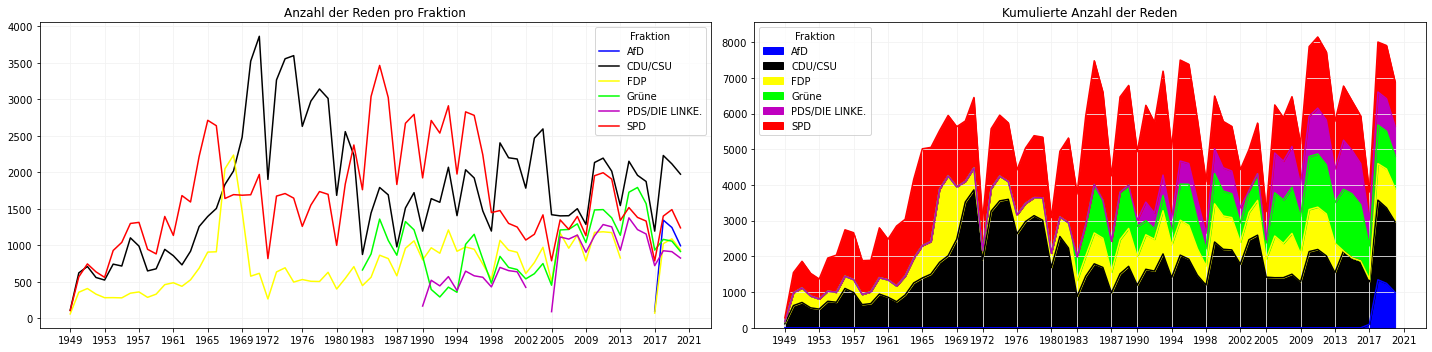

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1 = count_year_faction.unstack(level=0).plot(ax=ax1, kind='line', subplots=False, color=polit_colors)
ax2 = count_year_faction.unstack(level=0).plot(ax=ax2, kind='area', subplots=False, color=polit_colors)

fig.set_figheight(5)
fig.set_figwidth(20)


ax1.set_title("Anzahl der Reden pro Fraktion")
ax2.set_title("Kumulierte Anzahl der Reden")
ax1.grid(axis='both', color='0.95')
ax2.grid(axis='both', color='0.95')
ax1.set_xlabel("")
ax2.set_xlabel("")
ax1.set_xticks(election_years)
ax2.set_xticks(election_years)
ax1.legend(title="Fraktion", loc=1)
ax2.legend(title="Fraktion", loc=2)
plt.tight_layout()

Links sehen wir die Anzahl der Reden, die im jeweiligen Jahr von den unterschiedlichen Fraktionen gehalten wurden. Rechts ist die Anzahl der Reden kumuliert abgebildet. Wie oben bereits beschrieben, werden hier nur Reden von Fraktionen berücksichtigt, die in der aktuellen Wahlperiode im Bundestag vertreten sind. Die Wahljahre sind auf der x-Achse zu sehen.

# Frauenanteil unter den Redner:innen

In [22]:
ratio_female_year_faction = year_relevant_speeches.groupby("abbreviation").apply(lambda faction: faction.groupby("date").apply(lambda group: male_female_ratio(group)))

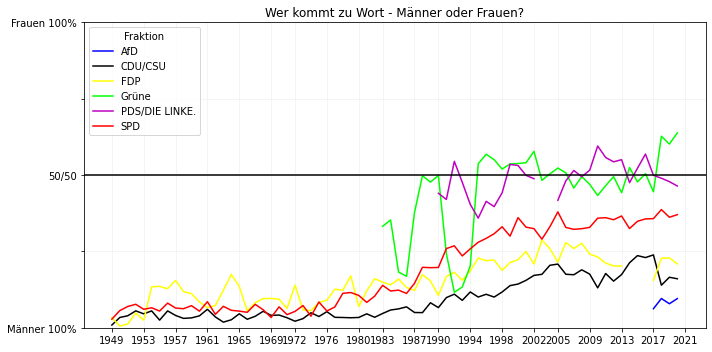

In [23]:
ax = ratio_female_year_faction.unstack(level=0).plot(kind='line', subplots=False, figsize=(10, 5), color=polit_colors)

plt.title("Wer kommt zu Wort - Männer oder Frauen?")
plt.ylim(0, 1)
ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['Männer 100%', '', '50/50', '', 'Frauen 100%'])
plt.axhline(0.5, 0, 1, color="black", linestyle="solid")
plt.grid(axis='both', color='0.95')
plt.xlabel("")
ax.set_xticks(election_years)
plt.legend(title="Fraktion", loc=2)
plt.tight_layout()

Diese ernüchternde Grafik spiegelt auch den Frauenanteil im aktuellen Bundestag wider: nur 31,4 % der Abgeordneten sind weiblich (Quelle: [Bundestag](https://www.bundestag.de/abgeordnete/biografien/mdb_zahlen_19/frauen_maenner-529508)). In der letzten Wahlperiode waren es noch 37,3 %.

# Redner:innen nach Alter

In [24]:
year_relevant_speeches["birthYear"] = year_relevant_speeches["birthYear"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)

In [25]:
year_relevant_speeches["age"] = year_relevant_speeches["date"] - year_relevant_speeches["birthYear"]

In [26]:
age_year_faction = year_relevant_speeches.groupby("abbreviation").apply(lambda faction: faction.groupby("date").apply(lambda group: group["age"].mean()))

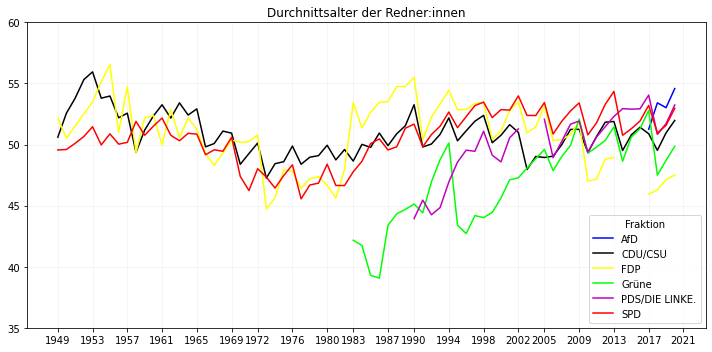

In [27]:
ax = age_year_faction.unstack(level=0).plot(kind='line', subplots=False, figsize=(10, 5), color=polit_colors)
plt.title("Durchnittsalter der Redner:innen")
plt.ylim(35, 60)
plt.grid(axis='both', color='0.95')
plt.xlabel("")
ax.set_xticks(election_years)
plt.legend(title="Fraktion", loc=4)
plt.tight_layout()

Für das Durchschnittsalter der Redner:innen werden jeweils das Geburtsjahr und das Jahr, in dem die Rede gehalten wurde, berücksichtigt. Interessanterweise gab es außer den vergleichsweise jungen Grünen in den 80ern und 90ern keine großen Veränderungen im Durchschnittsalter über die Jahrzehnte.

# Redner:innen mit akademischem Titel

In [28]:
year_relevant_speeches["academicTitle"].unique()

array(['Prof. Dr.', 'Dr.', nan, 'Prof.', 'Dr. - Ing. e. h.', 'Dr. - Ing.',
       'Dr. - Ing. Dr. h. c.', 'Dr. Dr. h. c.', 'Dr. h. c.',
       'Prof. Dr. h. c.', 'Dr. Dr.', 'Prof. Dr. Dr. h. c.',
       'Prof. Dr. Dr.', 'Dr. - Ing. Dr. - Ing. e. h. Dr. h. c.',
       'Prof. Dr. - Ing.', 'Dr. h. c. Dr. - Ing. e. h.', 'Dipl. - Ing.',
       'Dr. h. c. Dr. e. h.', 'Prof. h. c.'], dtype=object)

In [29]:
ratio_academic_year_faction = year_relevant_speeches.groupby("abbreviation").apply(lambda faction: faction.groupby("date").apply(lambda group: academic_ratio(group)))

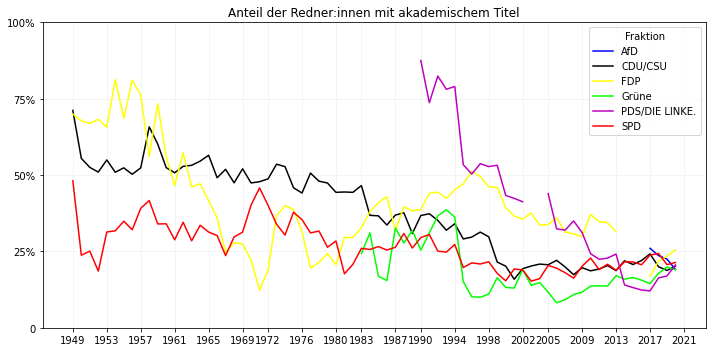

In [30]:
ax = ratio_academic_year_faction.unstack(level=0).plot(kind='line', subplots=False, figsize=(10, 5), color=polit_colors)
plt.title("Anteil der Redner:innen mit akademischem Titel")
plt.ylim(0, 1)
ax.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels([0, "25%", "50%", "75%", "100%"])
plt.grid(axis='both', color='0.95')
plt.xlabel("")
ax.set_xticks(election_years)
plt.legend(title="Fraktion", loc=1)
plt.tight_layout()

Wie oben aufgeführt werden hier nur Promotionen und Habilitation als akademische Titel gezählt. Anders als früher überwiegen nicht mehr die Titeltragenden unter den Redner:innen. Dieser Trend verläuft gegensätzlich zur Anzahl der Promotionen in Deutschland, die bis 2016 jährlich gestiegen ist (Quelle: [Wikipedia](https://de.wikipedia.org/wiki/Promotion_(Doktor)#Statistik)).

# Redner:innen nach Geburtsland

In [31]:
year_relevant_speeches["birthCountry"].unique()

array(['Deutschland', 'Ukraine', 'Finnland', 'Dänemark', 'Lettland',
       'Tansania (ehem. Deutsch-Ost-Afrika)', 'Niederlande',
       'Tschechoslowakei', 'Slowakei', 'Ceylon', 'Österreich',
       'Oberösterreich', 'Frankreich', 'Tonga-Insel, Südsee',
       '(damalige) CSR', 'Ungarn', 'Polen', 'Estland', 'Italien',
       'Australien', 'Schweiz', 'Russland', 'Kenia', 'Spanien', 'USA',
       'Jugoslawien', 'Türkei', 'CSSR', 'Rumänien', 'Tansania', 'CSFR',
       'Südwestafrika', 'Kroatien', 'Israel', 'Iran'], dtype=object)

In [32]:
ratio_birth_country_year_faction = year_relevant_speeches.groupby("abbreviation").apply(lambda faction: faction.groupby("date").apply(lambda group: birth_country_ratio(group)))

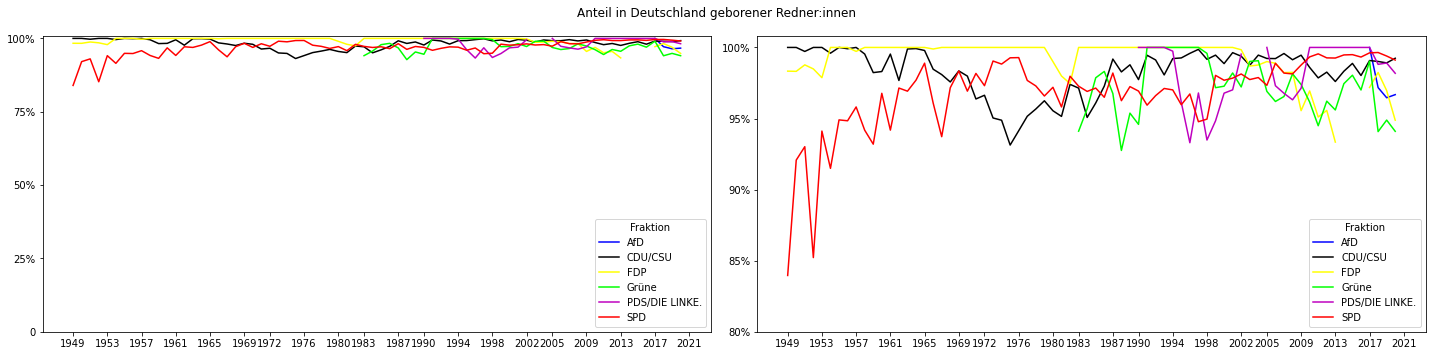

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1 = ratio_birth_country_year_faction.unstack(level=0).plot(ax=ax1, kind='line', subplots=False, color=polit_colors)
ax2 = ratio_birth_country_year_faction.unstack(level=0).plot(ax=ax2, kind='line', subplots=False, color=polit_colors)

fig.set_figheight(5)
fig.set_figwidth(20)

fig.suptitle("Anteil in Deutschland geborener Redner:innen")
ax1.set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
ax2.set_yticks([0.8, 0.85, 0.9, 0.95, 1.0])
ax1.set_yticklabels(["0", "25%", "50%", "75%", "100%"])
ax2.set_yticklabels(["80%", "85%", "90%", "95%", "100%"])
ax1.set_xlabel("")
ax2.set_xlabel("")
ax1.set_xticks(election_years)
ax2.set_xticks(election_years)
ax1.legend(title="Fraktion", loc=4)
ax2.legend(title="Fraktion", loc=4)
plt.tight_layout()

Das sind aber viele! Um die Unterschiede zwischen den Fraktionen besser erkennen zu können, haben wir rechts die y-Achse angepasst. Seit 1953 wurden in allen hier betrachteten Fraktionen über 90 % der Redner:innen in Deutschland geboren. Dabei hatten 2019 16,8 % der in Deutschland lebenden Menschen ein **anderes** Geburtsland als Deutschland (Quelle: [Statistisches Bundesamt](https://www.destatis.de/DE/Presse/Pressemitteilungen/2020/07/PD20_279_12511.html)). 

### Bonus: Aristokratie im Bundestag
Welche aristokratischen Titel waren schon im Bundestag vertreten?

In [34]:
year_relevant_speeches["aristocracy"].unique()

array([nan, 'Graf', 'Prinz', 'Freiherr', 'Baron', 'Frhr.'], dtype=object)